# Working on Data I

### 2023-04-06

Today, we will focus on text. We will try to understand the concepts of N-grams, TF-IDF, and Word2Vec. We will also try to understand the concepts of topic modeling and text classification.

In [2]:
# Reading the CSV files

with open('/workspaces/eastd143b_text_analysis/data/people_daily_titles.txt', 'r') as f1, open('/workspaces/eastd143b_text_analysis/data/japan_times_titles.txt', 'r') as f2:
    # Reading the contents of the first file
    people_daily_titles = f1.readlines()

    # Reading the contents of the second file
    japan_times_titles = f2.readlines()


## WordCloud

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
!pip install wordcloud

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

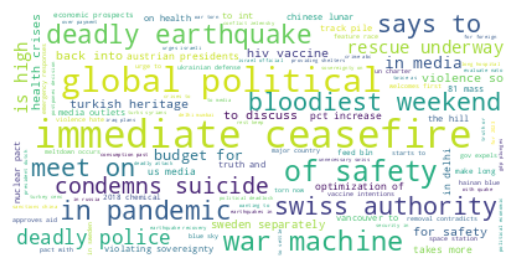

In [6]:
# Generating bigrams for the news titles from the People's Daily dataset
people_daily_vectorizer = CountVectorizer(ngram_range=(2, 2))
people_daily_bigrams = people_daily_vectorizer.fit_transform(
    people_daily_titles)


# Visualizing bigrams for the People's Daily dataset
people_daily_bigram_counts = people_daily_bigrams.sum(axis=0)
people_daily_bigram_dict = dict(zip(
    people_daily_vectorizer.vocabulary_.keys(), people_daily_bigram_counts.tolist()[0]))
people_daily_wordcloud = WordCloud(
    background_color='white').generate_from_frequencies(people_daily_bigram_dict)
plt.imshow(people_daily_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


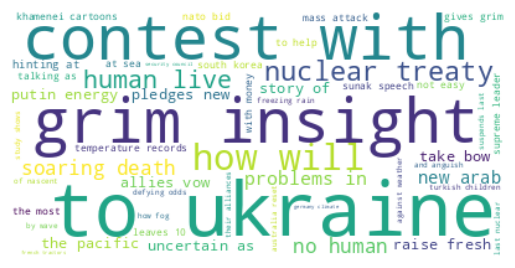

In [7]:
# Generating bigrams for the news titles from the Japan Times dataset
japan_times_vectorizer = CountVectorizer(ngram_range=(2, 2))
japan_times_bigrams = japan_times_vectorizer.fit_transform(japan_times_titles)

# Visualizing bigrams for the Japan Times dataset
japan_times_bigram_counts = japan_times_bigrams.sum(axis=0)
japan_times_bigram_dict = dict(zip(
    japan_times_vectorizer.vocabulary_.keys(), japan_times_bigram_counts.tolist()[0]))
japan_times_wordcloud = WordCloud(
    background_color='white').generate_from_frequencies(japan_times_bigram_dict)
plt.imshow(japan_times_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
# Calculating term frequency (TF) for the news titles in the People's Daily dataset
people_daily_vectorizer = CountVectorizer(stop_words='english')
people_daily_tf = people_daily_vectorizer.fit_transform(people_daily_titles)

# Calculating term frequency (TF) for the news titles in the Japan Times dataset
japan_times_vectorizer = CountVectorizer(stop_words='english')
japan_times_tf = japan_times_vectorizer.fit_transform(japan_times_titles)

# Calculating document frequency (DF) for the news titles in the People's Daily dataset
people_daily_df = people_daily_tf.astype(bool).sum(axis=0)

# Calculating document frequency (DF) for the news titles in the Japan Times dataset
japan_times_df = japan_times_tf.astype(bool).sum(axis=0)

# Calculating term frequency-inverse document frequency (TF-IDF) for the news titles in the People's Daily dataset
people_daily_tfidf_vectorizer = TfidfVectorizer()
people_daily_tfidf = people_daily_tfidf_vectorizer.fit_transform(
    people_daily_titles)

# Calculating term frequency-inverse document frequency (TF-IDF) for the news titles in the Japan Times dataset
japan_times_tfidf_vectorizer = TfidfVectorizer()
japan_times_tfidf = japan_times_tfidf_vectorizer.fit_transform(
    japan_times_titles)


## Principal Component Analysis (PCA)

In [8]:
from sklearn.decomposition import PCA
import numpy as np

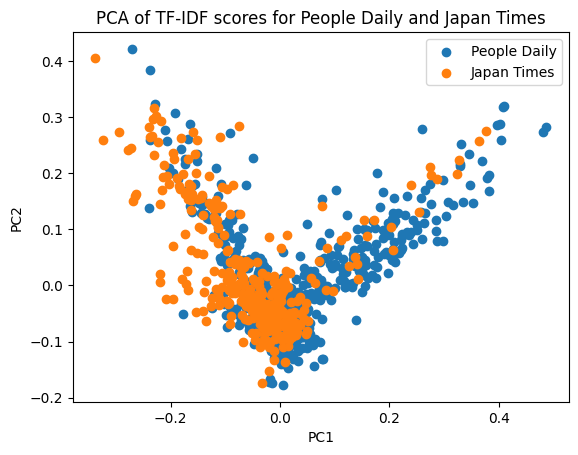

In [9]:

# Creating a TfidfVectorizer object with the same vocabulary for both datasets
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(people_daily_titles)
japan_times_tfidf = tfidf_vectorizer.transform(japan_times_titles)

# Concatenating the TF-IDF matrices of the two datasets
tfidf_concat = np.concatenate(
    [tfidf.toarray(), japan_times_tfidf.toarray()], axis=0)

# Performing PCA on the concatenated TF-IDF matrix
pca = PCA(n_components=2)
tfidf_pca = pca.fit_transform(tfidf_concat)

# Creating a scatter plot of the PCA results
plt.scatter(tfidf_pca[:len(people_daily_titles), 0], tfidf_pca[:len(
    people_daily_titles), 1], label='People Daily')
plt.scatter(tfidf_pca[len(people_daily_titles):, 0], tfidf_pca[len(
    people_daily_titles):, 1], label='Japan Times')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of TF-IDF scores for People Daily and Japan Times')
plt.legend()
plt.show()

## Topic Modeling

In [12]:
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

In [13]:
# Creating a CountVectorizer object to tokenize the news titles
people_daily_vectorizer = CountVectorizer(stop_words='english')
people_daily_counts = people_daily_vectorizer.fit_transform(
    people_daily_titles)

# Creating an LDA object to extract 10 topics from the news titles
lda = LatentDirichletAllocation(n_components=10, random_state=42)
people_daily_lda = lda.fit_transform(people_daily_counts)

# Creating a DataFrame to display the top words for each topic
people_daily_topics = pd.DataFrame(
    index=['Topic {}'.format(i) for i in range(1, 11)])

# Getting the top 10 words for each topic and adding them to the DataFrame
for i, topic in enumerate(lda.components_):
    people_daily_topics['Top Words for Topic {}'.format(
        i+1)] = [people_daily_vectorizer.get_feature_names_out()[j] for j in topic.argsort()[:-11:-1]]

# Displaying the DataFrame
display(people_daily_topics)


,Top Words for Topic 1,Top Words for Topic 2,Top Words for Topic 3,Top Words for Topic 4,Top Words for Topic 5,Top Words for Topic 6,Top Words for Topic 7,Top Words for Topic 8,Top Words for Topic 9,Top Words for Topic 10
Topic 1,ukraine,turkey,earthquake,int,new,russia,killed,ukraine,china,shooting
Topic 2,new,quake,turkey,says,biden,china,president,russia,covid,chinese
Topic 3,election,syria,china,pct,state,conflict,countries,conflict,feature,killed
Topic 4,speaker,hit,chinese,deaths,russia,ukraine,capital,crisis,turkey,covid
Topic 5,media,rescue,magnitude,ukraine,ukraine,facts,ukrainian,chinese,chinese,sanctions
Topic 6,house,aid,hits,china,china,ukrainian,amid,facts,rescue,long
Topic 7,eu,toll,covid,surpasses,global,violence,india,study,world,new
Topic 8,year,death,quake,continues,nord,president,injured,children,19,injured
Topic 9,violence,000,violence,death,stream,gun,eu,calls,team,19
Topic 10,chief,earthquake,gun,killed,world,west,meet,says,expert,experts


In [16]:
# Creating a CountVectorizer object to tokenize the news titles
japan_times_vectorizer = CountVectorizer(stop_words='english')
japan_times_counts = japan_times_vectorizer.fit_transform(
    japan_times_titles)

# Creating an LDA object to extract 10 topics from the news titles
lda = LatentDirichletAllocation(n_components=3, random_state=42)
japan_times_lda = lda.fit_transform(japan_times_counts)

# Creating a DataFrame to display the top words for each topic
japan_times_topics = pd.DataFrame(
    index=['Topic {}'.format(i) for i in range(1, 21)])

# Getting the top 10 words for each topic and adding them to the DataFrame
for i, topic in enumerate(lda.components_):
    japan_times_topics['Top Words for Topic {}'.format(
        i+1)] = [japan_times_vectorizer.get_feature_names_out()[j] for j in topic.argsort()[:-21:-1]]

# Displaying the DataFrame
display(japan_times_topics)

,Top Words for Topic 1,Top Words for Topic 2,Top Words for Topic 3
Topic 1,new,ukraine,ukraine
Topic 2,war,new,russia
Topic 3,children,covid,war
Topic 4,biden,balloon,turkey
Topic 5,putin,says,says
Topic 6,say,china,biden
Topic 7,russia,study,tanks
Topic 8,ukrainian,biden,allies
Topic 9,long,climate,kyiv
Topic 10,quake,trump,germany


In [ ]:
!pip install gensim
!pip install nltk

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
import string
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    # Convert the text to lowercase
    text = text.lower()

    # Remove punctuation characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text into words
    words = word_tokenize(text)

    # Return the preprocessed text as a string
    return ' '.join(words)


In [ ]:
import gensim
from gensim import corpora, models

# Preprocessing the data
people_daily_titles = [preprocess_text(title) for title in people_daily_titles]

# Converting the data into a numerical format
vectorizer = CountVectorizer(stop_words='english')
counts = vectorizer.fit_transform(people_daily_titles)

# Converting the counts into a Gensim-compatible format
corpus = gensim.matutils.Sparse2Corpus(counts, documents_columns=False)
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

# Performing LDA topic modeling
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus, id2word=id2word, num_topics=4, passes=10)

# Printing the topics
for idx, topic in lda_model.print_topics():
    print('Topic:', idx)
    print('Words:', topic)
    print()
